### Importing Libraries

In [5]:
seed = 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import pickle

### Loading Data

In [6]:
Xs = []
ys = []

Xs.append(pd.read_csv("../data/credit_X.csv"))
Xs.append(pd.read_csv("../data/raisin_X.csv"))
Xs.append(pd.read_csv("../data/alzheimer_X.csv"))
Xs.append(pd.read_csv("../data/salary_X.csv"))

ys.append(pd.read_csv("../data/credit_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/raisin_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/alzheimer_y.csv").iloc[:, 0])
ys.append(pd.read_csv("../data/salary_y.csv").iloc[:, 0])

### Functions

In [7]:
def tune_with_random_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        # in my case works faster with n_jobs=-1
        opt = RandomizedSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed, n_jobs=-1)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def tune_with_bayes_search(model, search_grid, n_iter, scoring):
    opt_results = []
    for i in range(4):
        opt = BayesSearchCV(model, search_grid, n_iter=n_iter, cv=5, scoring=scoring, random_state=seed)
        opt_results.append(opt.fit(Xs[i], ys[i]))
    return opt_results

def get_tunability(model_class, default_grid, tuned_grids, scoring):
    tunabilities = []
    for i in range(4):
        # Replace key "model__hiperparameter" to key "hiperparameter"
        cleaned_params = {key.replace('gbc__', ''): value for key, value in tuned_grids[i].best_params_.items()}
        pipe_default = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**default_grid))
        ])
        pipe_tuned = Pipeline(steps=[
            ("preprocessing", MinMaxScaler()),
            ("model", model_class(**cleaned_params))
        ])

        default_score = cross_val_score(pipe_default, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tuned_score = cross_val_score(pipe_tuned, Xs[i], ys[i], cv=5, scoring=scoring, n_jobs=-1).mean()
        tunabilities.append(tuned_score - default_score)
    return tunabilities

def save_result(result, path_to_save):
    with open(path_to_save, 'wb') as file:
        pickle.dump(result, file)

def load_result(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [12]:
pipe_gbc = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbc', GradientBoostingClassifier())
    ]

)

search_grid={
    'gbc__n_estimators': np.arange(50, 201, 50),
    'gbc__learning_rate': np.linspace(0.01, 0.2, 5),
    'gbc__max_depth': np.arange(3, 11),
    'gbc__min_samples_split': [i for i in range(2,11)],
    'gbc__min_samples_leaf': [i for i in range(1,11)],
    'gbc__subsample': np.linspace(0.6, 1.0, 4),
    'gbc__max_features': [None, 'sqrt', 'log2'],
    'gbc__random_state': [seed]
}

In [13]:
%%time

gbc_opt_results_rs = tune_with_random_search(pipe_gbc, search_grid,100, 'roc_auc')

CPU times: user 4.81 s, sys: 1.06 s, total: 5.87 s
Wall time: 2min 44s


In [14]:
save_result(gbc_opt_results_rs,'./saved_results/gbc_opt_results_rs.pkl')

In [15]:
for i in range(4):
    print(gbc_opt_results_rs[i].best_params_)

{'gbc__subsample': 0.6, 'gbc__random_state': 17, 'gbc__n_estimators': 50, 'gbc__min_samples_split': 2, 'gbc__min_samples_leaf': 3, 'gbc__max_features': None, 'gbc__max_depth': 3, 'gbc__learning_rate': 0.0575}
{'gbc__subsample': 1.0, 'gbc__random_state': 17, 'gbc__n_estimators': 200, 'gbc__min_samples_split': 10, 'gbc__min_samples_leaf': 8, 'gbc__max_features': 'log2', 'gbc__max_depth': 8, 'gbc__learning_rate': 0.01}
{'gbc__subsample': 1.0, 'gbc__random_state': 17, 'gbc__n_estimators': 100, 'gbc__min_samples_split': 9, 'gbc__min_samples_leaf': 9, 'gbc__max_features': None, 'gbc__max_depth': 10, 'gbc__learning_rate': 0.105}
{'gbc__subsample': 1.0, 'gbc__random_state': 17, 'gbc__n_estimators': 100, 'gbc__min_samples_split': 4, 'gbc__min_samples_leaf': 1, 'gbc__max_features': 'sqrt', 'gbc__max_depth': 4, 'gbc__learning_rate': 0.0575}


In [17]:
gbc_tunabilities_rs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_rs, 'roc_auc')
gbc_tunabilities_rs

[0.011476553417342883,
 0.006851851851851998,
 0.011578779917354232,
 -0.0003574365048031325]

### Bayesian Optimization

In [18]:
pipe_gbc = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbc', GradientBoostingClassifier())
    ]

)

search_grid={
    'gbc__n_estimators': np.arange(50, 201, 50),
    'gbc__learning_rate': np.linspace(0.01, 0.2, 5),
    'gbc__max_depth': np.arange(3, 11),
    'gbc__min_samples_split': [i for i in range(2,11)],
    'gbc__min_samples_leaf': [i for i in range(1,11)],
    'gbc__subsample': np.linspace(0.6, 1.0, 4),
    'gbc__max_features': [None, 'sqrt', 'log2'],
    'gbc__random_state': [seed]
}

In [19]:
%%time

gbc_opt_results_bs = tune_with_bayes_search(pipe_gbc, search_grid,100, 'roc_auc')

CPU times: user 3h 10min 22s, sys: 1h 34min 52s, total: 4h 45min 15s
Wall time: 55min 16s


In [20]:
save_result(gbc_opt_results_bs,'./saved_results/gbc_opt_results_bs.pkl')

In [21]:
for i in range(4):
    print(gbc_opt_results_bs[i].best_params_)

OrderedDict([('gbc__learning_rate', 0.01), ('gbc__max_depth', 5), ('gbc__max_features', None), ('gbc__min_samples_leaf', 1), ('gbc__min_samples_split', 6), ('gbc__n_estimators', 150), ('gbc__random_state', 17), ('gbc__subsample', 0.6)])
OrderedDict([('gbc__learning_rate', 0.0575), ('gbc__max_depth', 7), ('gbc__max_features', 'sqrt'), ('gbc__min_samples_leaf', 3), ('gbc__min_samples_split', 8), ('gbc__n_estimators', 50), ('gbc__random_state', 17), ('gbc__subsample', 0.7333333333333333)])
OrderedDict([('gbc__learning_rate', 0.15250000000000002), ('gbc__max_depth', 9), ('gbc__max_features', None), ('gbc__min_samples_leaf', 7), ('gbc__min_samples_split', 4), ('gbc__n_estimators', 200), ('gbc__random_state', 17), ('gbc__subsample', 1.0)])
OrderedDict([('gbc__learning_rate', 0.0575), ('gbc__max_depth', 3), ('gbc__max_features', 'sqrt'), ('gbc__min_samples_leaf', 2), ('gbc__min_samples_split', 10), ('gbc__n_estimators', 150), ('gbc__random_state', 17), ('gbc__subsample', 0.6)])


In [22]:
gbc_tunabilities_bs = get_tunability(GradientBoostingClassifier, {'random_state': seed}, gbc_opt_results_bs, 'roc_auc')

gbc_tunabilities_bs

[0.02417429062165899,
 0.00876543209876568,
 0.011391098027904834,
 0.0034478220818527916]

### Plots

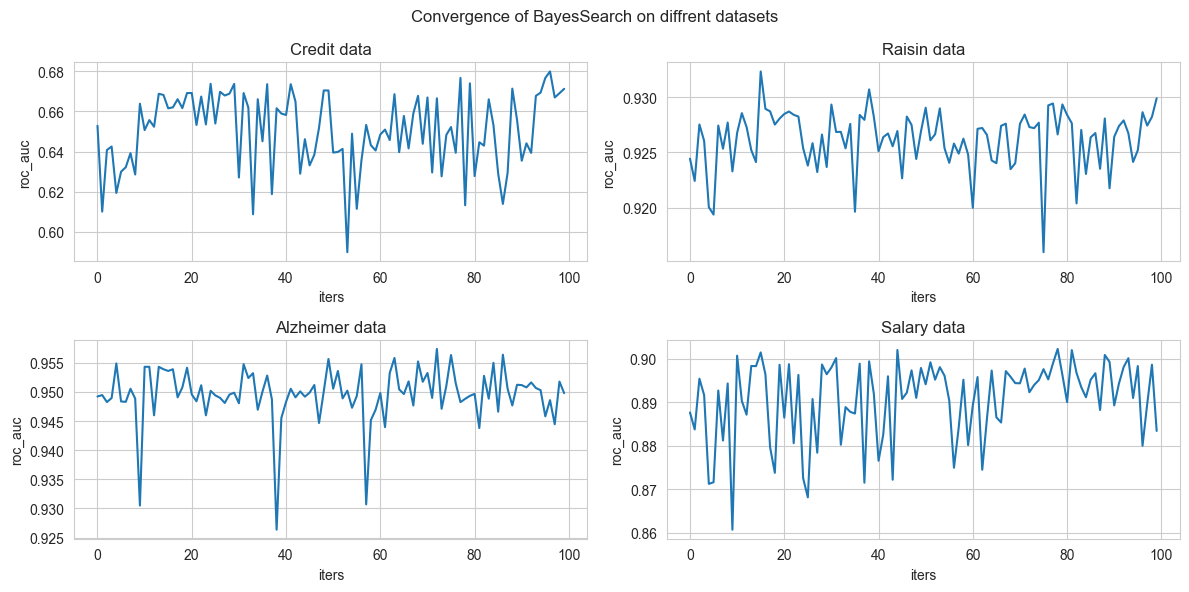

In [23]:
titles = ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
axs = axs.flatten()
fig.suptitle("Convergence of BayesSearch on diffrent datasets")
for i in range(4):
    axs[i].plot(gbc_opt_results_bs[i].cv_results_["mean_test_score"])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("iters")
    axs[i].set_ylabel("roc_auc")
plt.tight_layout()
plt.show()

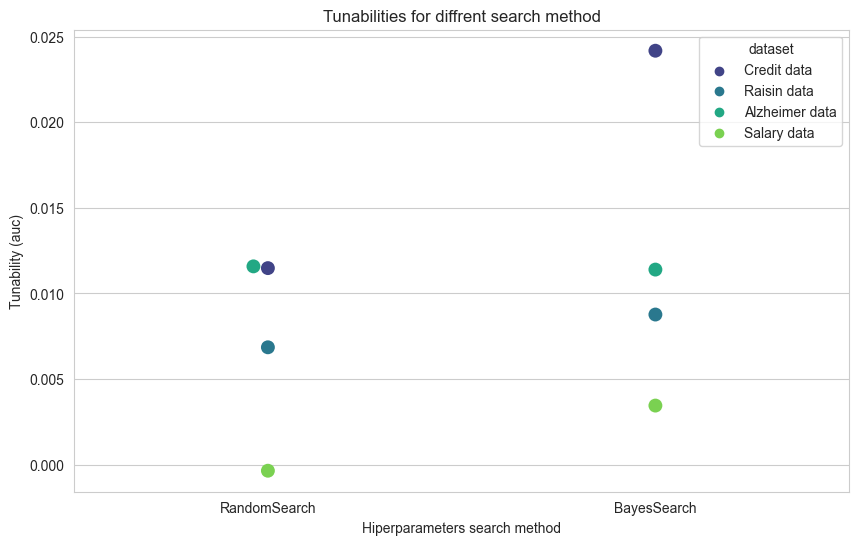

In [24]:
data = {
    'tunability': gbc_tunabilities_rs + gbc_tunabilities_bs,
    'alg': ["RandomSearch"] *  4 + ["BayesSearch"] * 4,
    'dataset': ["Credit data", "Raisin data", "Alzheimer data", "Salary data"]*2
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.swarmplot(x='alg', y='tunability', hue='dataset', data=df, palette='viridis', size=10)

plt.title('Tunabilities for diffrent search method')
plt.xlabel('Hiperparameters search method')
plt.ylabel('Tunability (auc)')
plt.show()